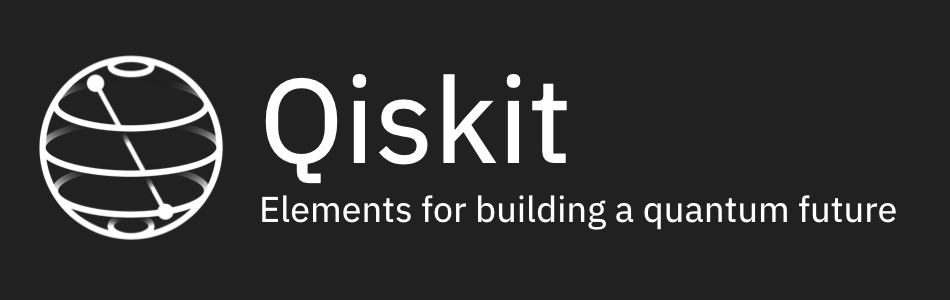

# Qiskit Runtime on IBM Cloud

Qiskit Runtime is now part of the IBM Quantum Services on IBM Cloud. To use this service, you'll need to create an IBM Cloud account and a quantum service instance. [This guide](https://cloud.ibm.com/docs/account?topic=account-account-getting-started) contains step-by-step instructions on setting up the account and [this page](https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-quickstart) explains how to create a service instance, including directions to find your IBM Cloud API key and Cloud Resource Name (CRN), which you will need later in this tutorial. 



This tutorial assumes that you know how to use Qiskit, including using it to create circuits. If you are not familiar with Qiskit, the [Qiskit Textbook](https://qiskit.org/textbook/preface.html) is a great resource to learn about both Qiskit and quantum computation in general. 

# qiskit-ibm-runtime

Once you have an IBM Cloud account and service instance set up, you can use `qiskit-ibm-runtime` to access Qiskit Runtime on IBM Cloud. `qiskit-ibm-runtime` provides the interface to interact with Qiskit Runtime. You can, for example, use it to query and execute runtime programs.

## Installation

You can install the `qiskit-ibm-runtime` package using pip:

```
pip install qiskit-ibm-runtime
```

## Account initialization

Before you can start using Qiskit Runtime, you need to initialize your account by calling `QiskitRuntimeService` with your IBM Cloud API key and the CRN or service name of your service instance.

You can also choose to save your credentials on disk (in the `$HOME/.qiskit/qiskit-ibm.json` file). By doing so, you only need to use `QiskitRuntimeService()` in the future to initialize your account.

For more information about account management, such as how to delete or view an account, see [04_account_management.ipynb](04_account_management.ipynb). 

<div class="alert alert-block alert-info">
<b>Note:</b> Account credentials are saved in plain text, so only do so if you are using a trusted device. 
</div>

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save account on disk.
# QiskitRuntimeService.save_account(channel="ibm_cloud", token=<IBM Cloud API key>, instance=<IBM Cloud CRN> or <IBM Cloud service name>)

service = QiskitRuntimeService()

The `<IBM Cloud API key>` in the example above is your IBM Cloud API key and looks something like

```
kYgdggnD-qx5k2u0AAFUKv3ZPW_avg0eQ9sK75CCW7hw
```

The `<IBM Cloud CRN>` is the Cloud Resource Name and looks something like

```
crn:v1:bluemix:public:quantum-computing:us-east:a/b947c1c5a9378d64aed96696e4d76e8e:a3a7f181-35aa-42c8-94d6-7c8ed6e1a94b::
```

The `<IBM Cloud service name>` is user-provided and defaults to something like
```
Quantum Services-9p
```
If you choose to set `instance` to the service name, the initialization time of the `QiskitRuntimeService` is slightly higher because the required `CRN` value is internally resolved via IBM Cloud APIs.

## Listing programs <a name='listing_program'>

There are three methods that can be used to find metadata of available programs:

- `pprint_programs()`: pretty prints summary metadata of available programs
- `programs()`: returns a list of `RuntimeProgram` instances
- `program()`: returns a single `RuntimeProgram` instance

The metadata of a runtime program includes its ID, name, description, maximum execution time, backend requirements, input parameters, and return values. Maximum execution time is the maximum amount of time, in seconds, a program can run before being forcibly terminated.

To print the summary metadata of the programs (by default first 20 programs are displayed):

In [2]:
service.pprint_programs(limit=None)

hello-world:
  Name: hello-world
  Description: Get started by running this simple test program.
sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
estimator:
  Name: estimator
  Description: Calculates expectation values of quantum operators.


You can use the `limit` and `skip` parameters in `pprint_programs()` and `programs()` to page through all programs. 

You can pass `detailed=True` parameter to `pprint_programs()` to view all the metadata for the programs. 

The program metadata, once fetched, is cached for performance reasons. But you can pass the `refresh=True` parameter  to get the latest data from the server. 

To print the metadata of the program `sampler`:

In [3]:
program = service.program("sampler")
print(program)

sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
  Creation date: 2021-10-26T14:41:57Z
  Update date: 2022-05-11T14:35:25.79967Z
  Max execution time: 10000
  Backend requirements:
    none
  Input parameters:
    Properties:
        - circuit_indices:
            Description: Indices of the circuits to evaluate.
            Type: array
            Required: True
        - circuits:
            Description: A single or list of QuantumCircuits.
            Type: ['array', 'object']
            Required: True
        - parameter_values:
            Description: A list of concrete parameters to be bound for each circuit. If specified, it must have the same length as circuit_indices.
            Type: array
            Required: False
        - parameters:
            Description: Parameters of the quantum circuits.
            Type: array
            Required: False
        - run_options:
            Description: A collection of key-value

As you can see from above, the primitive `sampler` calculates the distributions generated by given circuits executed on the target backend. It takes a number of parameters, but `circuits` and `circuit_indices` are the only required parameters. When the program finishes, it returns the quasi-probabilities for each circuit.

## Invoking a runtime program <a name='invoking_program'>

You can use the [QiskitRuntimeService.run()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.run) method to invoke a runtime program. This method takes the following parameters:

- `program_id`: ID of the program to run.
- `inputs`: Program input parameters. These input values are passed to the runtime program.
- `options`: Runtime options. These options control the execution environment. Currently the only available option is `backend_name`, which is optional for cloud runtime.
- `result_decoder`: Optional class used to decode the job result.

Below is an example of invoking the `sampler` program.

First we need to construct a circuit as the input to `sampler` using Qiskit.

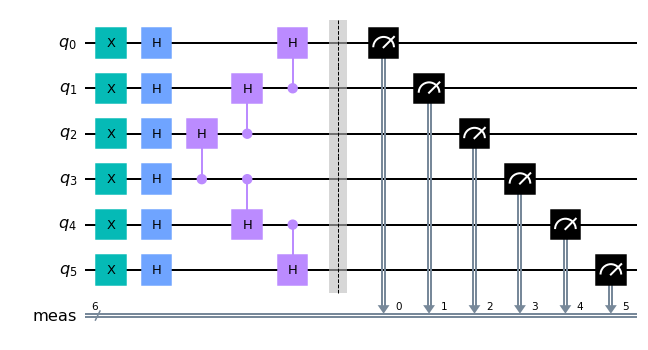

In [4]:
from qiskit import QuantumCircuit

N = 6
qc = QuantumCircuit(N)

qc.x(range(0, N))
qc.h(range(0, N))

for kk in range(N // 2, 0, -1):
    qc.ch(kk, kk - 1)
for kk in range(N // 2, N - 1):
    qc.ch(kk, kk + 1)
qc.measure_all()
qc.draw("mpl", fold=-1)

We now use this circuit as the input to `sampler`:

In [5]:
# Specify the program inputs here.
program_inputs = {
    "circuits": qc,
    "circuit_indices": [0],
}

job = service.run(
    program_id="sampler",
    inputs=program_inputs,
)

# Printing the job ID in case we need to retrieve it later.
print(f"Job ID: {job.job_id}")

# Get the job result - this is blocking and control may not return immediately.
result = job.result()
print(result)
# see which backend the job was executed on
print(job.backend) 

Job ID: caat1colee5v49iqrde0
{'quasi_dists': [{'100000': 0.013671875, '100001': 0.01171875, '000001': 0.0185546875, '100011': 0.0361328125, '110111': 0.1416015625, '111111': 0.478515625, '110011': 0.05859375, '110000': 0.0322265625, '110001': 0.0263671875, '000000': 0.0107421875, '000011': 0.02734375, '000111': 0.078125, '100111': 0.06640625}], 'metadata': [{'header_metadata': {}, 'shots': 1024}]}
<IBMBackend('ibmq_qasm_simulator')>


### Runtime job

The `run()` method returns a [RuntimeJob](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.RuntimeJob.html#qiskit_ibm_runtime.RuntimeJob) instance, which represents the asynchronous execution instance of the program. 

Some of the `RuntimeJob` methods:

- `status()`: Return job status.
- `result()`: Wait for the job to finish and return the final result.
- `cancel()`: Cancel the job.
- `wait_for_final_state()`: Wait for the job to finish.
- `logs()`: Return job logs.
- `error_message()`: Returns the reason if the job failed and `None` otherwise.

Some of the `RuntimeJob` attributes:

- `job_id`: Unique identifier of the job.
- `backend`: The backend where the job is run.
- `program_id`: ID of the program the execution is for.


Refer to the [RuntimeJob API documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.RuntimeJob.html#qiskit_ibm_runtime.RuntimeJob) for a full list of methods and usage. 

<div class="alert alert-block alert-info">
<b>Note:</b> To ensure fairness, there is a maximum execution time for each Qiskit Runtime job. Refer to <a href="https://qiskit.org/documentation/partners/qiskit_ibm_runtime/max_time.html#qiskit-runtime-on-ibm-cloud">this documentation</a> on what the time limit is.
</div>

## Selecting a backend

A **backend** is a quantum device or simulator capable of running quantum circuits or pulse schedules.

In the example above, we invoked a runtime program without specifying which backend it should run on. In this case the server automatically picks the one that is the least busy. Alternatively, you can choose a specific backend to run your program. 

To list all the backends you have access to:

In [6]:
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>]

The [QiskitRuntimeService.backends()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.backends) method also takes filters. For example, to find all real devices that have at least five qubits:

In [7]:
service.backends(simulator=False, min_num_qubits=5)

[]

[QiskitRuntimeService.backends()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.backends) returns a list of [IBMBackend](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.IBMBackend.html#qiskit_ibm_runtime.IBMBackend) instances. Each instance represents a particular backend. Attributes and methods of an `IBMBackend` provide more information about the backend, such as its qubit count, error rate, and status.

For more information about backends, such as commonly used attributes, see [03_backends.ipynb](03_backends.ipynb).

Once you select a backend to use, you can specify the name of the backend in the `options` parameter:

In [8]:
# Specify the program inputs here.
program_inputs = {
    "circuits": qc,
    "circuit_indices": [0],
}

# Specify the backend name.
options = {"backend_name": "ibmq_qasm_simulator"}

job = service.run(
    program_id="sampler",
    options=options,
    inputs=program_inputs,
)

# Printing the job ID in case we need to retrieve it later.
print(f"Job ID: {job.job_id}")

# Get the job result - this is blocking and control may not return immediately.
result = job.result()
print(result)

Job ID: caat1eglee5v49iqrdf0
{'quasi_dists': [{'100000': 0.0146484375, '000001': 0.021484375, '100011': 0.0302734375, '110111': 0.123046875, '111111': 0.494140625, '110000': 0.0283203125, '110011': 0.072265625, '000000': 0.0126953125, '100111': 0.0654296875, '000111': 0.0595703125, '000011': 0.0380859375, '100001': 0.0185546875, '110001': 0.021484375}], 'metadata': [{'header_metadata': {}, 'shots': 1024}]}


## Retrieving previously run jobs

You can use the [QiskitRuntimeService.job()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.job) method to retrieve a previously executed runtime job. Attributes of this [RuntimeJob](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.RuntimeJob.html#qiskit_ibm_runtime.RuntimeJob) instance can tell you about the execution:

In [9]:
retrieved_job = service.job(job.job_id)
print(
    f"Job {retrieved_job.job_id} is an execution instance of runtime program {retrieved_job.program_id}."
)
print(
    f"This job ran on backend {retrieved_job.backend} and had input parameters {retrieved_job.inputs}"
)

Job caat1eglee5v49iqrdf0 is an execution instance of runtime program sampler.
This job ran on backend <IBMBackend('ibmq_qasm_simulator')> and had input parameters {'circuits': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f9b509829a0>, 'circuit_indices': [0]}


Similarly, you can use [QiskitRuntimeService.jobs()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.jobs) to get a list of jobs. You can specify a limit on how many jobs to return. The default limit is 10:

In [10]:
retrieved_jobs = service.jobs(limit=1)
for rjob in retrieved_jobs:
    print(rjob.job_id)

caat1eglee5v49iqrdf0


## Deleting a job

You can use the [QiskitRuntimeService.delete_job()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.delete_job) method to delete a job. You can only delete your own jobs, and this action cannot be reversed. 

In [11]:
service.delete_job(job.job_id)

# Next steps

There are additional tutorials in this directory:

- [02_introduction_ibm_quantum_runtime.ipynb](02_introduction_ibm_quantum_runtime.ipynb) is the corresponding tutorial on using Qiskit Runtime on IBM Quantum. You can skip this tutorial if you don't plan on using Qiskit Runtime on IBM Quantum.
- [03_backends.ipynb](03_backends.ipynb) describes how to find a target backend for the Qiskit Runtime program you want to invoke. 
- [04_account_management.ipynb](04_account_management.ipynb) describes how to save, load, and delete your account credentials on disk.
- [qiskit_runtime_vqe_program.ipynb](sample_vqe_program/qiskit_runtime_vqe_program.ipynb) goes into more details on uploading a real-world program (VQE). 
- [qka.ipynb](qka.ipynb), [vqe.ipynb](vqe.ipynb), and [qiskit_runtime_expval_program.ipynb](sample_expval_program/qiskit_runtime_expval_program.ipynb) describe how to use the public programs `qka`, `vqe`, and `sample-expval`, respectively. These programs are currently only available in Qiskit Runtime on IBM Quantum.

In [12]:
from qiskit.tools.jupyter import *

%qiskit_copyright